## LangChain:

LangChain utiliza una estructura de flujo de trabajo basada en código, lo que significa que los flujos de trabajo se escriben y gestionan a través de código en Python. Este enfoque es sencillo para los desarrolladores familiarizados con la programación, ya que les permite definir el flujo mediante scripts sin necesidad de herramientas adicionales.
El diseño modular de LangChain permite a los usuarios vincular diferentes tareas a través de scripts y funciones personalizadas, lo que brinda flexibilidad, pero puede requerir código más complejo para flujos de trabajo intrincados.

## LangGraph:

LangGraph, por otro lado, se estructura en torno a un modelo basado en gráficos o declarativo que enfatiza la representación visual. Los usuarios pueden crear y gestionar flujos de trabajo a través de una interfaz gráfica, lo que lo hace más accesible para aquellos que pueden no tener una experiencia amplia en programación.
Este enfoque visual ayuda a comprender las dependencias complejas, facilitando el seguimiento y la gestión de las interacciones de tareas dentro de un flujo de trabajo complejo.m

In [70]:
from num2words import num2words

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def int_to_text(a: int) -> str:
    """Convert int to text in words.

    Args:
        a: int
    """
    return num2words(a)

In [71]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Cargar las variables del archivo .env
load_dotenv()

# Leer la clave API desde el archivo .env
api_key = os.getenv("OPENAI_API_KEY")

# Configurar el modelo de OpenAI
model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

# Usar el modelo con herramientas
tools = [add, multiply, divide, int_to_text]
llm_with_tools = model.bind_tools(tools)


In [72]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithemetic on a set  if inputs.")

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

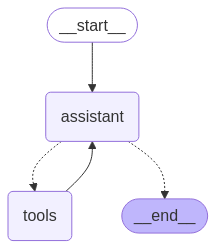

In [73]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Gráfico
builder = StateGraph(MessagesState)

# Definir nodos: estos realizan el trabajo
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Definir bordes: estos determinan cómo se mueve el flujo de control
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # Si el último mensaje (resultado) del asistente es una llamada a una herramienta -> tools_condition redirige a tools.
    # Si el último mensaje (resultado) del asistente no es una llamada a una herramienta -> tools_condition redirige a END.
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Mostrar
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memoria
La memoria es crucial para los agentes, ya que les permite retener y utilizar información a lo largo de múltiples pasos en la resolución de problemas. Opera en diferentes escalas:

- **Memoria a corto plazo:** Permite al agente acceder a la información adquirida durante los pasos anteriores en una secuencia.

- **Memoria a largo plazo:** Permite al agente recordar información de interacciones previas, como mensajes pasados en una conversación.

In [74]:
messages = [HumanMessage(content="Suma 3 y 4.")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_KCWObfbIzt5wrx5x5fGRduS4)
 Call ID: call_KCWObfbIzt5wrx5x5fGRduS4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

La suma de 3 y 4 es 7.


No retenemos la memoria de 7 de nuestro chat inicial.

Esto se debe a que el estado es transitorio en una única ejecución del gráfico.

Por supuesto, esto limita nuestra capacidad para tener conversaciones de múltiples turnos con interrupciones.

Podemos usar la persistencia para solucionar esto.

LangGraph puede usar un checkpoint para guardar automáticamente el estado del gráfico después de cada paso.

Esta capa de persistencia integrada nos proporciona memoria, permitiendo que LangGraph continúe desde la última actualización del estado.

Uno de los checkpoints más fáciles de usar es MemorySaver, un almacenamiento en memoria basado en clave-valor para el estado del gráfico.

Todo lo que necesitamos hacer es simplemente compilar el gráfico con un checkpoint, ¡y nuestro gráfico tendrá memoria!

In [75]:
messages = [HumanMessage(content="Ahora multiplicalo por 7")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Ahora multiplicalo por 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vUYObfhxl7LjLkquKfKSUHvd)
 Call ID: call_vUYObfhxl7LjLkquKfKSUHvd
  Args:
    a: 2
    b: 7
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

El resultado de multiplicar 2 por 7 es 14.


## Agregando Memoria al Agente

In [76]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)


Cuando usamos memoria, necesitamos especificar un `thread_id`.

Este `thread_id` almacenará nuestra colección de estados del gráfico.

### Explicación con un esquema:
- El checkpoint escribe el estado en cada paso del gráfico.
- Estos checkpoints se guardan en un hilo (thread).
- Podemos acceder a ese hilo en el futuro usando el `thread_id`.

![Esta es una imagen de ejemplo](img/thread.png "Imagen de ejemplo")




In [77]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Suma 3 y 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Djq8l2y8eYBEHq2R0u5cI91w)
 Call ID: call_Djq8l2y8eYBEHq2R0u5cI91w
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

La suma de 3 y 4 es 7.



Si pasamos el mismo `thread_id`, entonces podemos continuar desde el último estado guardado en el checkpoint.

En este caso, la conversación anterior queda almacenada en el hilo (thread).

El `HumanMessage` que enviamos (`"Multiplicalo por 2."`) se agrega a la conversación anterior.

Por lo tanto, el modelo ahora sabe que `that` se refiere a **"The sum of 3 and 4 is 7."**.

In [78]:
messages = [HumanMessage(content = "Multiplicalo por 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Djq8l2y8eYBEHq2R0u5cI91w)
 Call ID: call_Djq8l2y8eYBEHq2R0u5cI91w
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

La suma de 3 y 4 es 7.
================================ Human Message =================================

Multiplicalo por 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_OHTYKCdX2yKq4tTrmNT8XfaN)
 Call ID: call_OHTYKCdX2yKq4tTrmNT8XfaN
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplicando 7 por 2, e

In [79]:
messages = [HumanMessage(content = "Escribelo en palabras.")]
messages = react_graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Djq8l2y8eYBEHq2R0u5cI91w)
 Call ID: call_Djq8l2y8eYBEHq2R0u5cI91w
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

La suma de 3 y 4 es 7.
================================ Human Message =================================

Multiplicalo por 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_OHTYKCdX2yKq4tTrmNT8XfaN)
 Call ID: call_OHTYKCdX2yKq4tTrmNT8XfaN
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplicando 7 por 2, e